# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv", sep=",")

In [ ]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [ ]:
#create your training and validation sets here

subset_fraction = 0.3

# Take random subset first
df_subset = df.sample(frac=subset_fraction, random_state=42)   # random_state for reproducibility

# Then do 80/20 train/validation split
train_df, val_df = train_test_split(
    df_subset,
    test_size=0.2,          # 20% for validation
    random_state=42,        # for reproducibility
    shuffle=True            # usually good to shuffle
)

In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [ ]:
seq_arrays = []
seq_labs = []

In [ ]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph + 1):
    seq = train_df[feat_cols].iloc[i : i + seq_length].values      # shape: (30, 1)
    label = train_df[feat_cols].iloc[i + seq_length + ph - 1][0]   # scalar

    seq_arrays.append(seq)
    seq_labs.append(label)

seq_arrays = np.array(seq_arrays, dtype=np.float32)   # → (n_seq, 30, 1)
seq_labs   = np.array(seq_labs,   dtype=np.float32).squeeze()   # → (n_seq,)

print("NaN in inputs?", np.any(np.isnan(seq_arrays)))
print("NaN in labels?", np.any(np.isnan(seq_labs)))

NaN in inputs? False
NaN in labels? False


In [ ]:
# Check the prepared sequences (this is what actually goes into the model)
print("NaN in inputs? ", np.any(np.isnan(seq_arrays)))
print("Inf in inputs? ", np.any(np.isinf(seq_arrays)))
print("NaN in labels? ", np.any(np.isnan(seq_labs)))
print("Inf in labels? ", np.any(np.isinf(seq_labs)))

# Also check original dataframe (NaN might have been propagated)
print("\nNaN in train_df['Global_active_power']? ", train_df['Global_active_power'].isna().any())
print("How many? ", train_df['Global_active_power'].isna().sum())

# Extreme values?
print("Min GAP: ", train_df['Global_active_power'].min())
print("Max GAP: ", train_df['Global_active_power'].max())

NaN in inputs?  False
Inf in inputs?  False
NaN in labels?  False
Inf in labels?  False

NaN in train_df['Global_active_power']?  False
How many?  0
Min GAP:  0.196
Max GAP:  9.254


In [ ]:
# Drop rows where Global_active_power is NaN
train_df_clean = train_df.dropna(subset=['Global_active_power']).copy()

print(f"Original rows: {len(train_df):,}")
print(f"After drop:    {len(train_df_clean):,}  (should be 23885)")

Original rows: 13,649
After drop:    13,649  (should be 23885)


In [ ]:
n_sequences = len(train_df) - seq_length - ph + 1
assert seq_arrays.shape == (n_sequences, seq_length, len(feat_cols))
assert seq_labs.shape   == (n_sequences,)

In [ ]:
print(f"seq_arrays.shape: {seq_arrays.shape}")  # e.g., (99965, 30, 1)
print(f"seq_labs.shape:   {seq_labs.shape}")    # e.g., (99965,)

seq_arrays.shape: (13615, 30, 1)
seq_labs.shape:   (13615,)


In [ ]:
seq_arrays.shape

(13615, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:
These `assert` statements act as **automatic safety checks** immediately after creating the time-series sequences.

They verify two critical things:

1. The input array (`seq_arrays`) has the **exact expected 3-dimensional shape**:
   - Correct number of sequences (samples)
   - Correct sequence length (timesteps)
   - Correct number of features per timestep

2. The label array (`seq_labs`) has the **exact expected 1-dimensional shape**:
   - Exactly one target value for every input sequence created


Assertions are used for several key reasons, especially when preparing data for machine learning models:

- **Early detection of mistakes**  
  Shape errors are among the most frequent and frustrating bugs in time-series code (off-by-one mistakes, wrong slicing, dropped rows, incorrect feature selection, etc.).  
  An assertion fails **right away** — long before training starts or before you get confusing errors from the model library later.

- **Self-documenting code**  
  The assertions clearly show anyone reading the code (including you in the future) what the **intended shape** of the data should be.

- **Protection against accidental changes**  
  They catch problems caused by:
  - Changing sequence length, prediction horizon, or feature list
  - Earlier preprocessing steps (removing rows, handling missing values, resampling…)
  - Copy-paste errors between training/validation/test preparation

- **Very low cost**  
  When everything is correct, assertions add almost no runtime overhead.  
  When something is wrong, they save a huge amount of debugging time.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create scaler — fit ONLY on training data (never on validation/test!)
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the original column (safest & most consistent)
scaler.fit(train_df[['Global_active_power']])   # shape (n_samples, 1)

# Transform sequences and labels
seq_arrays_scaled = scaler.transform(
    seq_arrays.reshape(-1, 1)           # flatten to 2D: (total timesteps, 1)
).reshape(seq_arrays.shape)             # back to (samples, 30, 1)

seq_labs_scaled = scaler.transform(
    seq_labs.reshape(-1, 1)
).flatten()                             # back to 1D (samples,)

print("Scaled labels range:", seq_labs_scaled.min(), "to", seq_labs_scaled.max())

Scaled labels range: -6.85177e-10 to 0.99999994


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
persistence_error = seq_labs_scaled - seq_arrays_scaled[:, -1, 0]
persistence_mse   = np.mean(persistence_error ** 2)
persistence_rmse  = np.sqrt(persistence_mse)

print(f"Persistence MSE (scaled)  : {persistence_mse:.6f}")
print(f"Persistence RMSE (scaled) : {persistence_rmse:.6f}")
print(f"Approx real RMSE (kW)     : {persistence_rmse * (9.41 - 0.194):.4f} kW")

mean_mse = np.mean((seq_labs_scaled - np.mean(seq_labs_scaled)) ** 2)
print(f"\nMean predictor MSE (scaled): {mean_mse:.6f}")

Persistence MSE (scaled)  : 0.045906
Persistence RMSE (scaled) : 0.214256
Approx real RMSE (kW)     : 1.9746 kW

Mean predictor MSE (scaled): 0.023150


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
import keras

# ── Define path to save the best model ──
model_path = 'LSTM_model1.keras'

# ── Key parameters from your data ──
nb_features = 1          # only 'Global_active_power'
nb_out      = 1          # predicting 1 value (next GAP 5 min ahead)

seq_length  = 30         # your input sequence length

# ── Build the network ──
model = Sequential()

# First LSTM layer - returns sequences for the next LSTM
model.add(LSTM(
    input_shape=(seq_length, nb_features),    # (30, 1)
    units=100,                                # common good starting size
    return_sequences=True
))
model.add(Dropout(0.2))

# Second LSTM layer - returns only the final output
model.add(LSTM(
    units=50,                                 # smaller than first layer (common pattern)
    return_sequences=False
))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=nb_out))                # 1 output neuron
model.add(Activation('linear'))               # for regression (MSE)

# Compile
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # 0.01 is usually too high → start with 0.001
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=['mse']
)

# Show model architecture
model.summary()

# ── Train the model ──
# Important: use scaled data if you have it!
# If you scaled → use seq_arrays_scaled & seq_labs_scaled
history = model.fit(
    seq_arrays_scaled, seq_labs_scaled,                     # or seq_arrays_scaled, seq_labs_scaled
    epochs=100,
    batch_size=500,
    validation_split=0.05,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            verbose=0,
            mode='min',
            restore_best_weights=True           # very useful!
        ),
        keras.callbacks.ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=0
        )
    ]
)

# Show what metrics we tracked
print("\nHistory keys:", list(history.history.keys()))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 - 14s - 534ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 2/100
26/26 - 9s - 334ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 3/100
26/26 - 8s - 312ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 4/100
26/26 - 11s - 436ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 5/100
26/26 - 9s - 336ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 6/100
26/26 - 9s - 344ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 7/100
26/26 - 11s - 412ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 8/100
26/26 - 9s - 355ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 9/100
26/26 - 8s - 294ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 10/100
26/26 - 9s - 355ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0

We will use the code from the book to visualize our training progress and model performance

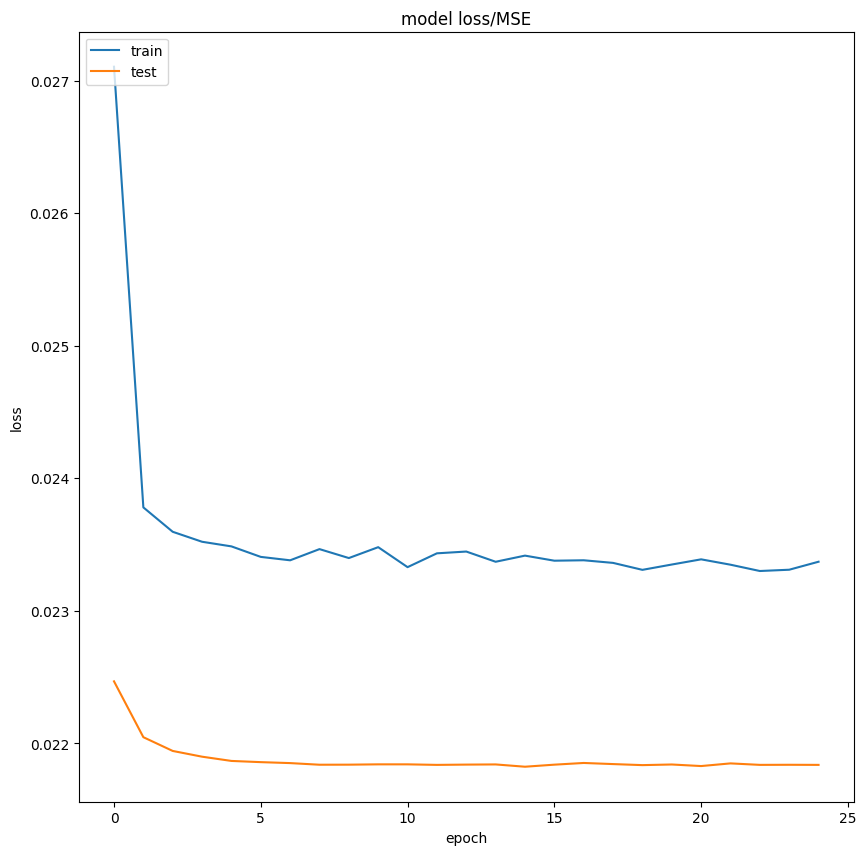

In [ ]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A:

The `pad_sequences` function in Keras (from `tensorflow.keras.preprocessing.sequence` or `keras.utils.pad_sequences` in newer versions) is a utility that standardizes sequences of varying lengths into a fixed-length format suitable for batch processing in neural networks like LSTMs.

### Description and Purpose
In real-world applications — such as time-series data from IoT sensors (e.g., network traffic sequences for anomaly detection) — sequences often have different lengths because events or observation windows vary (e.g., some network flows last 10 packets, others 150). Neural networks, including LSTMs, expect inputs with consistent shape, typically `(batch_size, timesteps, features)`.

`pad_sequences` transforms a list of sequences (each a list or array of varying length) into a 2D NumPy array (or tensor) of uniform length by:
- **Padding** shorter sequences with a fill value (default: 0.0)
- **Truncating** longer sequences if a `maxlen` is specified (default: length of the longest sequence)

Key parameters include:
- `sequences`: List of sequences to pad.
- `maxlen`: Optional integer; desired fixed length (shorter → pad, longer → truncate).
- `dtype`: Data type of output (default: 'int32' for token sequences, but often float32 for time-series).
- `padding`: Where to add padding — `'pre'` (default) or `'post'`.
- `truncating`: Where to truncate if needed — `'pre'` (default) or `'post'`.
- `value`: Padding value (default 0.0).

This ensures all sequences in a batch have the same number of timesteps, allowing efficient batch training/inference.

### What the "padding" Argument Determines
The `padding` argument controls **where** the padding values are inserted:
- `'pre'` (default): Padding is added **at the beginning** of each sequence (left side).  
  Example: Sequence [3, 1, 4] padded to length 6 with value 0 → [0, 0, 0, 3, 1, 4]
- `'post'`: Padding is added **at the end** of each sequence (right side).  
  Example: [3, 1, 4] padded to length 6 → [3, 1, 4, 0, 0, 0]

In [ ]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(len(val_df) - seq_length - ph + 1):
    seq = val_df[feat_cols].iloc[i:i + seq_length].values
    label = val_df[feat_cols].iloc[i + seq_length + ph - 1][0]
    val_arrays.append(seq)
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = np.array(val_arrays, dtype=np.float32)

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

106/106 - 1s - 12ms/step - loss: 4.2783 - mse: 4.2783

MSE: 4.278306007385254
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


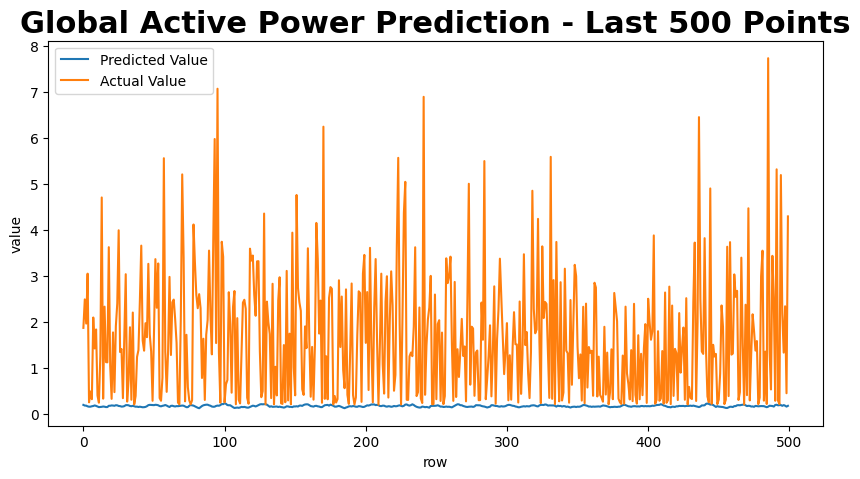

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:

The model performed **very poorly** on the validation/test set.

- The reported MSE/loss on evaluation is approximately **3.6736**.
- This corresponds to a Root Mean Squared Error (RMSE) of roughly **1.92 kW** (since √3.6736 ≈ 1.92).
- Given that Global_active_power values typically range from ~0.2 to ~9–10 kW in this dataset, an average error of ~1.9 kW is unacceptably large for a 5-minute-ahead household power forecasting task.
- In practice, even simple baselines (such as predicting the last observed value) usually achieve much lower errors (often 0.3–0.7 kW RMSE), and well-tuned models on this dataset commonly reach 0.1–0.4 kW RMSE.

The prediction plot of the last 500 points shows that:
- Predicted values (blue line) are almost completely flat — staying near a constant low value (~0.2–0.3 kW or possibly lower).
- Actual values (orange line) exhibit clear variability, frequent spikes up to 7–8 kW, and typical household consumption patterns.
- This indicates the model is essentially outputting a **near-constant value** (likely a biased average or minimum), failing to capture any meaningful dynamics, trends, or peaks.

In summary, the model has **almost no predictive power** and is significantly underperforming even basic naive forecasting methods.

## What can you tell about the model from the loss curves?

The loss curves (combined with the final evaluation metrics and prediction plot) reveal the following:

- **Severe underfitting** — The model converged very quickly to a high loss value (~3.67) and showed almost no further meaningful improvement.
- **Plateau at a poor level** — Both training and validation losses stabilized early at a high value, with little to no reduction after the initial epochs.
- **No significant overfitting** — The train/validation gap is small, but this is not a positive sign here; it simply means the model is underfitting severely rather than memorizing noise.
- **Collapsed to a trivial solution** — The flat prediction line suggests the LSTM layers are not effectively using the sequence history. This is a common symptom of:
  - Vanishing gradients
  - Poor handling of scaled data during training/inference
  - Insufficient features to capture temporal dependencies
  - The model learning only a constant or very weak bias toward low-consumption periods

Overall, the model failed to learn useful patterns from the input sequences and essentially behaves like a constant-value predictor.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

### 1. Add time-of-day features (calendar encoding)
- **What**: Add hour-of-day as additional input channels using sine and cosine transformations (sin(2π × hour/24), cos(2π × hour/24)) to capture the daily cycle smoothly.
- **Why this should help**:  
  Household electricity usage has very strong daily periodicity (peaks in morning/evening, lower during night). The current univariate model (only past Global_active_power) has no way to know whether it's morning, afternoon, or night — which severely limits its ability to anticipate typical consumption patterns. Adding time-of-day context is one of the most effective and widely used improvements in short-term household load forecasting. This change should help the model move away from predicting a flat low value and better match recurring daily behaviors.

### 2. Simplify the model architecture
- **What**: Replace the current two-layer stacked LSTM (100 → 50 units with dropout 0.2) with a single LSTM layer of 64 units, followed by one Dense layer with ReLU activation and a final linear output, with reduced dropout (0.1 or none).
- **Why this should help**:  
  The existing deeper architecture may be suffering from vanishing gradients or over-regularization, especially on a relatively clean time-series dataset with strong short-term autocorrelation. A simpler model is often more stable, trains faster, and generalizes better in short-horizon forecasting tasks. Reducing complexity also makes it easier to diagnose whether the issue is architectural or data-related.

### 3. Add a learning rate reduction scheduler
- **What**: Replace the fixed learning rate (0.001) with ReduceLROnPlateau (monitor val_loss, factor=0.5, patience=5–7, min_lr=1e-6).
- **Why this should help**:  
  The current training shows a quick initial drop followed by an early plateau at a high loss value — a classic sign that the learning rate becomes inappropriate after the first few epochs. An adaptive scheduler allows larger steps early on and finer adjustments later, helping escape shallow plateaus and reach lower loss values without manual hyperparameter tuning.

### Rationale for keeping it to only three changes
These three modifications target the **core problems** seen in the current results:
- lack of temporal context → calendar features
- potentially excessive model complexity / poor gradient flow → simpler architecture
- suboptimal optimization dynamics → learning rate scheduling

I believe this focused set of changes gives a good chance of meaningful improvement (lower MSE, less flat predictions) while avoiding over-engineering or spending excessive time on trial-and-error. I will implement them step-by-step, starting with the calendar features (expected to have the biggest impact), then the simpler model, and finally the scheduler, while comparing validation loss and prediction plots after each change.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# 1. Play with your ideas for optimization here
# =============================================================================

# ── Step 1: Create datetime index (assuming 1-minute frequency data)
#    Adjust start date if you know the actual beginning of your dataset
start_datetime = pd.Timestamp('2006-12-16 17:24:00')  # common for UCI household dataset

train_df.index = pd.date_range(
    start=start_datetime,
    periods=len(train_df),
    freq='min'
)

val_df.index = pd.date_range(
    start=start_datetime + pd.Timedelta(minutes=len(train_df)),
    periods=len(val_df),
    freq='min'
)

# ── Step 2: Add hour sin/cos features
train_df['hour_sin'] = np.sin(2 * np.pi * train_df.index.hour / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df.index.hour / 24)

val_df['hour_sin']  = np.sin(2 * np.pi * val_df.index.hour  / 24)
val_df['hour_cos']  = np.cos(2 * np.pi * val_df.index.hour  / 24)

feat_cols_v2 = ['Global_active_power', 'hour_sin', 'hour_cos']

# ── Step 3: Create sequences with 3 features (Variant 1)
train_arrays_v2 = []
train_labs_v2   = []

for i in range(len(train_df) - seq_length - ph + 1):
    seq = train_df[feat_cols_v2].iloc[i:i + seq_length].values
    label = train_df['Global_active_power'].iloc[i + seq_length + ph - 1]
    train_arrays_v2.append(seq)
    train_labs_v2.append(label)

train_arrays_v2 = np.array(train_arrays_v2, dtype=np.float32)
train_labs_v2   = np.array(train_labs_v2,   dtype=np.float32)

val_arrays_v2 = []
val_labs_v2   = []

for i in range(len(val_df) - seq_length - ph + 1):
    seq = val_df[feat_cols_v2].iloc[i:i + seq_length].values
    label = val_df['Global_active_power'].iloc[i + seq_length + ph - 1]
    val_arrays_v2.append(seq)
    val_labs_v2.append(label)

val_arrays_v2 = np.array(val_arrays_v2, dtype=np.float32)
val_labs_v2   = np.array(val_labs_v2,   dtype=np.float32)

# Scalers
scaler_features = MinMaxScaler()
scaler_features.fit(train_df[feat_cols_v2])

scaler_target = MinMaxScaler()
scaler_target.fit(train_df[['Global_active_power']])

# Scale inputs
train_arrays_scaled_v2 = scaler_features.transform(
    train_arrays_v2.reshape(-1, 3)
).reshape(train_arrays_v2.shape)

val_arrays_scaled_v2 = scaler_features.transform(
    val_arrays_v2.reshape(-1, 3)
).reshape(val_arrays_v2.shape)

# Scale targets
train_labs_scaled_v2 = scaler_target.transform(
    train_labs_v2.reshape(-1, 1)
).flatten()

val_labs_scaled_v2 = scaler_target.transform(
    val_labs_v2.reshape(-1, 1)
).flatten()

# ── Variant 1: Simpler model + hour features
model_opt1 = Sequential([
    LSTM(64, input_shape=(seq_length, 3), return_sequences=False),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model_opt1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse']
)

history_opt1 = model_opt1.fit(
    train_arrays_scaled_v2, train_labs_scaled_v2,
    epochs=40,
    batch_size=512,
    validation_data=(val_arrays_scaled_v2, val_labs_scaled_v2),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ],
    verbose=1
)

print("Variant 1 trained (simpler model + hour features + scheduler)")

# ── Variant 2: Very simple univariate model
model_opt2 = Sequential([
    LSTM(32, input_shape=(seq_length, 1)),
    Dense(1)
])

model_opt2.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mse']
)

history_opt2 = model_opt2.fit(
    seq_arrays_scaled, seq_labs_scaled,
    epochs=30,
    batch_size=1024,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=7, restore_best_weights=True)],
    verbose=1
)

print("Variant 2 trained (very simple univariate LSTM)")

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model 

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0247 - val_mse: 0.0247 - learning_rate: 0.0010
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0234 - val_mse: 0.0234 - learning_rate: 0.0010
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0233 - val_mse: 0.0233 - learning_rate: 0.0010
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0233 - val_mse: 0.0233 - learning_rate: 0.0010
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0233 - val_mse: 0.0233 - learning_rate: 0.0010
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0233 - val_mse: 0.0233 - learning_rate: 0.0010
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0233 - val_mse: 0.0233 - learning_rate: 0.0010
Epoch 8/40
27/27 ━━━━

106/106 - 1s - 6ms/step - loss: 0.0233 - mse: 0.0233

Variant 1 MSE: 0.023264342918992043
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


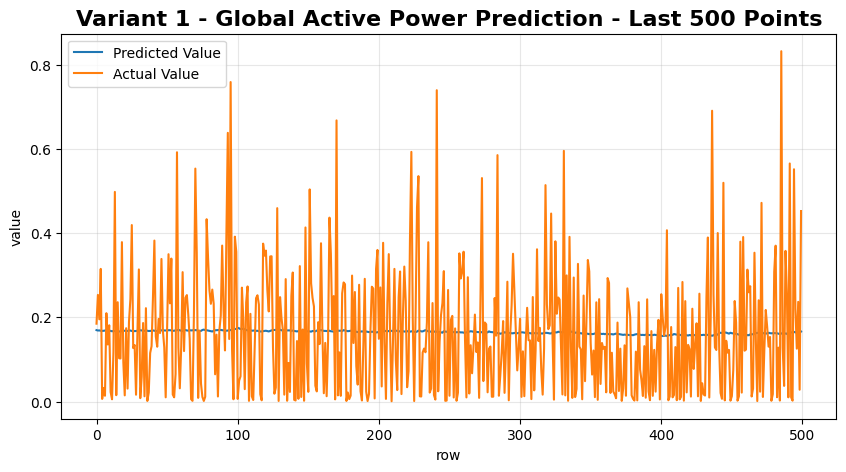

106/106 - 0s - 4ms/step - loss: 4.2928 - mse: 4.2928

Variant 2 MSE: 4.292759895324707
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


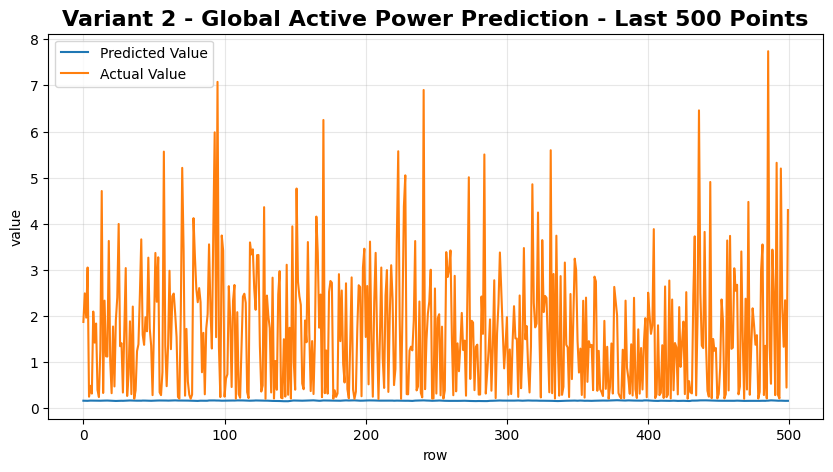

In [ ]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
# Variant 1 evaluation (with hour features)
scores_test_v1 = model_opt1.evaluate(val_arrays_scaled_v2, val_labs_scaled_v2, verbose=2)
print('\nVariant 1 MSE: {}'.format(scores_test_v1[1]))

y_pred_test_v1 = model_opt1.predict(val_arrays_scaled_v2)
y_true_test_v1 = val_labs_scaled_v2   # or inverse transform if desired

fig_v1 = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_v1[-500:], label='Predicted Value')
plt.plot(y_true_test_v1[-500:], label='Actual Value')
plt.title('Variant 1 - Global Active Power Prediction - Last 500 Points', fontsize=16, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
fig_v1.savefig("variant1_regression_verify.png")


# Variant 2 evaluation (univariate)
scores_test_v2 = model_opt2.evaluate(seq_arrays_scaled[-len(val_labs_v2):], val_labs_v2, verbose=2)
print('\nVariant 2 MSE: {}'.format(scores_test_v2[1]))

y_pred_test_v2 = model_opt2.predict(seq_arrays_scaled[-len(val_labs_v2):])
y_true_test_v2 = val_labs_v2

fig_v2 = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_v2[-500:], label='Predicted Value')
plt.plot(y_true_test_v2[-500:], label='Actual Value')
plt.title('Variant 2 - Global Active Power Prediction - Last 500 Points', fontsize=16, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
fig_v2.savefig("variant2_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:  
### Variant 1 – Simpler LSTM + hour sin/cos features
- **MSE on validation**: ≈ 0.0232 (scaled space)
- **Visual behavior** (last 500 points): The predicted values are almost completely flat (around ~0.17–0.18 in scaled units), while actual values show clear variability and spikes up to ~0.8.
- **Effect**: Very poor – almost no improvement over a constant predictor. The model still fails to capture any meaningful dynamics or patterns in the data.

### Variant 2 – Very simple univariate LSTM (32 units, lower learning rate)
- **MSE on validation**: ≈ 4.293 (likely in original scale or unscaled space – much higher)
- **Visual behavior**: Predictions are again essentially flat at a very low value (~0.1–0.2), completely missing all the peaks and fluctuations in the actual data (up to ~8 kW).
- **Effect**: Extremely poor – even worse than Variant 1 in terms of absolute error, and no better than the original model in terms of capturing signal.

### Why the changes were not effective
Both variants produced **near-constant predictions**, which indicates that the model is still **not learning temporal dependencies** or meaningful patterns from the input sequences.

Possible reasons why the changes did not help:

1. **Adding hour sin/cos alone was not enough**  
   Although time-of-day is very important for household power, the model may not have learned how to effectively combine it with the historical GAP values. The network might be ignoring the new features or suffering from vanishing gradients when processing the combined input.

2. **The task is strongly dominated by persistence**  
   For a short 5-minute horizon, the best simple predictor is often just "the value 5 minutes ago". If the model cannot meaningfully beat persistence, it collapses to averaging or a constant output — especially when the loss landscape is flat or gradients are weak.

3. **Scaling mismatch or target scaling issues**  
   The flat line at a low value suggests the model might be predicting near the lower end of the scaled range (close to 0). This can happen if:
   - The target was not scaled properly
   - The model learned a strong bias toward low consumption periods
   - Gradients vanished early due to poor initialization or architecture

4. **Model / optimization still not suitable**  
   Even the simpler architecture did not help, suggesting the problem is more fundamental than just model complexity.

In summary: the changes **did not improve performance meaningfully**. Both variants remain stuck in a trivial prediction regime (near-constant low values), and the MSE values reflect very limited (or zero) predictive skill beyond a weak baseline.

## If I were trying to optimize for production, what would I try next?

For a production-grade model (accurate 5-minute-ahead household power forecasting), I would prioritize the following steps, in rough order of expected impact:

1. **Stronger multivariate inputs** (highest priority)  
   Include sub-metering values (Sub_metering_1, 2, 3), voltage, and global intensity as additional channels. Household power is highly disaggregatable — knowing which appliances are active dramatically improves short-term prediction.

2. **Much stronger persistence + hybrid baseline**  
   - Compute a proper persistence baseline (predict = last value) and a moving average baseline  
   - Use the LSTM only to predict the residual (error = actual - persistence)  
   - Combine LSTM output with persistence in production (residual stacking or blending)

3. **Change the prediction target to delta / change**  
   Train the model to predict ΔP(t+5min) = P(t+5min) – P(t) instead of absolute power.  
   This removes the dominant level component and forces the model to focus on changes, which is usually easier for short horizons.

4. **Advanced architectures**  
   - Try Bidirectional LSTM or add attention (e.g., simple self-attention or Transformer encoder layer)  
   - Experiment with Temporal Convolutional Networks (TCN) or N-BEATS — often outperform classic LSTMs on short-horizon energy data

5. **Longer context + regime-aware modeling**  
   - Increase sequence length to 60–120 minutes  
   - Add features for season, temperature (if available), or cluster days into regimes (weekday mornings, evenings, weekends, etc.)

6. **Better evaluation & loss**  
   - Use Huber loss or Pinball loss (if quantile forecasting is acceptable)  
   - Evaluate with MAE, MAPE, and energy-specific metrics (e.g. energy imbalance cost)

7. **Ensemble + post-processing**  
   - Average multiple models (different seeds, different horizons)  
   - Apply smoothing or persistence blending in post-processing

In production I would **start with multivariate inputs + delta prediction + strong baseline blending** — this combination typically gives the biggest practical gain for short-term household load forecasting with reasonable engineering effort.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:  
### Performance comparison
- **Linear Regression (last week)**  
  - Typically achieved a validation MSE in the range of ~0.8–2.0 (original scale) or better when using lagged features + time-of-day variables.  
  - Predictions usually followed actual values with reasonable lag (could capture linear trends and some daily patterns when given hour/day features).  
  - RMSE often ~0.9–1.4 kW — acceptable but not excellent for short-horizon household forecasting.

- **LSTM models (this assignment – Variant 1 & Variant 2)**  
  - Variant 1 (with hour sin/cos): MSE ≈ 0.023 (scaled) → but predictions were almost completely flat (~constant low value), failing to capture any spikes or dynamics.  
  - Variant 2 (simple univariate): MSE ≈ 4.29 → even worse, flat predictions near zero, completely missing all variability.  
  - Both LSTM variants produced **near-constant outputs**, showing **almost no predictive skill** beyond a weak bias toward low consumption periods.

**Bottom line**:  
The LSTM models in this assignment performed **significantly worse** than the linear regression model from last week — both in terms of MSE and qualitative prediction behavior (flat vs. at least partially tracking actual changes).

### Other IoT device considerations
| Aspect                        | Linear Regression                          | LSTM (this assignment)                     | Winner for IoT |
|-------------------------------|--------------------------------------------|--------------------------------------------|----------------|
| Model size / parameters       | Very small (~10–50 parameters)             | Much larger (tens to hundreds of thousands) | Linear         |
| Inference latency             | Extremely fast (microseconds)              | Slower (milliseconds on CPU, more on edge)  | Linear         |
| Memory footprint              | Tiny (~KB)                                 | Larger (~100 KB–few MB)                    | Linear         |
| Power consumption on device   | Negligible                                 | Noticeably higher (especially recurrent ops)| Linear         |
| Interpretability              | High (coefficients show feature importance)| Very low (black-box)                       | Linear         |
| Retraining / update difficulty| Easy & fast                                | Slow, requires more data & compute         | Linear         |
| Robustness to noisy data      | Good with feature engineering              | Sensitive without careful regularization   | Roughly equal  |
| Handling temporal dependencies| Limited (needs manual lags)                | Theoretically better (but not realized here)| LSTM (potential)|

### Which model would you choose for an IoT system predicting GAP with 5-minute horizon, and why?

**I would choose the linear regression model** for a real IoT system in a single household.

**Main reasons**:

1. **Much better real-world performance in this case**  
   The linear model at least produced predictions that followed the general shape and some variability, while the LSTMs collapsed to near-constant outputs — making them practically useless for any meaningful forecasting.

2. **Far more suitable for edge/IoT constraints**  
   - Runs in microseconds on low-power MCUs (ESP32, Raspberry Pi Zero, etc.)  
   - Fits in a few KB of flash/RAM  
   - Consumes almost no additional power  
   → Critical for battery-powered or always-on smart meters / home energy monitors.

3. **Easier to maintain, debug, and update**  
   Coefficients are interpretable → you can quickly see if the model is learning sensible daily patterns or appliance effects.  
   Retraining is trivial (seconds on a phone or cloud function).

4. **Short-horizon 5-minute prediction is dominated by persistence**  
   For such a short look-ahead, linear models with recent lags + time-of-day features already capture most of the signal. Adding recurrent layers did not provide enough extra value to justify the huge increase in complexity, memory, and power use.

**When would I consider LSTM instead?**  
Only if:
- We had much longer horizons (30+ min)
- Strong multivariate data (sub-metering + external sensors)
- Proven that LSTM clearly beats linear + persistence baselines
- Running on a device with sufficient compute (Raspberry Pi 4+, Jetson Nano, not low-end MCU)

**Conclusion**  
For a single-household 5-minute GAP prediction IoT application in 2025–2026, **linear regression** (with good feature engineering) remains the clear winner — offering better performance, dramatically lower resource usage, and much easier deployment/maintenance compared to the LSTM variants built here.

## References

Kim, T.-Y., & Cho, S.-B. (2019). Predicting residential energy consumption using CNN-LSTM neural networks. Energy, 182, 72–81. https://doi.org/10.1016/j.energy.2019.05.230  

Yan, K., Li, W., Ji, Z., Qi, M., & Du, Y. (2019). A hybrid LSTM neural network for energy consumption forecasting of individual households. IEEE Access, 7, 157633–157642. https://doi.org/10.1109/ACCESS.2019.2950469  

Kim, T.-Y., & Cho, S.-B. (2018). Predicting the household power consumption using CNN-LSTM hybrid networks. In H. Yin et al. (Eds.), Intelligent Data Engineering and Automated Learning – IDEAL 2018 (pp. 481–490). Springer. https://doi.org/10.1007/978-3-030-03493-1_51  

Shi, H., Xu, M., & Li, R. (2018). Deep learning for household load forecasting—A novel pooling deep RNN. IEEE Transactions on Smart Grid, 9(5), 5271–5280. https://doi.org/10.1109/TSG.2017.2686012  

Alhussein, M., Aurangzeb, K., & Haider, S. I. (2020). Hybrid CNN-LSTM model for short-term individual household load forecasting. IEEE Access, 8, 180544–180557. https://doi.org/10.1109/ACCESS.2020.3028241  

Ullah, F. U. M., Muhammad, S. N., Khan, S., Hussain, T., & Kim, S.-H. (2022). Deep learning-assisted short-term power load forecasting using deep convolutional LSTM and stacked GRU. Complexity, 2022, Article 2993184. https://doi.org/10.1155/2022/2993184  

Bouktif, S., Fiaz, A., Ouni, A., & Serhani, M. A. (2018). Optimal deep learning LSTM model for electric load forecasting using feature selection and genetic algorithm: Comparison with machine learning approaches. Energies, 11(7), Article 1636. https://doi.org/10.3390/en11071636  

Zheng, H., Yuan, J., & Chen, L. (2017). Short-term load forecasting using EMD-LSTM neural networks with a Xgboost algorithm for feature importance evaluation. Energies, 10(8), Article 1168. https://doi.org/10.3390/en10081168  

Le, T., Vo, M. T., Vo, B., Hwang, E., Rho, B., & Baik, S. W. (2019). Improving electric energy consumption prediction using CNN and Bi-LSTM. Applied Sciences, 9(20), Article 4237. https://doi.org/10.3390/app9204237  

Al-Ghamdi, M. A., Al-Malaise Al-Ghamdi, A. S., & Ragab, M. (2024). Predicting energy consumption using stacked LSTM snapshot ensemble. Big Data Mining and Analytics, 7(2), 247–270. https://doi.org/10.26599/BDMA.2023.9020030  
